In [177]:
from requests import get
from requests.exceptions import RequestException
from contextlib import closing
from bs4 import BeautifulSoup
import re
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
def simple_get(url):
    """
    Attempts to get the content at `url` by making an HTTP GET request.
    If the content-type of response is some kind of HTML/XML, return the
    text content, otherwise return None.
    """
    try:
        with closing(get(url, stream=True)) as resp:
            if is_good_response(resp):
                return resp.content
            else:
                return None

    except RequestException as e:
        log_error('Error during requests to {0} : {1}'.format(url, str(e)))
        return None
    
def is_good_response(resp):
    """
    Returns True if the response seems to be HTML, False otherwise.
    """
    content_type = resp.headers['Content-Type'].lower()
    return (resp.status_code == 200 
            and content_type is not None 
            and content_type.find('html') > -1)


def log_error(e):
    """
    It is always a good idea to log errors. 
    This function just prints them, but you can
    make it do anything.
    """
    print(e)

In [93]:
raw_html = simple_get(url = r'https://www.blocket.se/goteborg/bilar?cg=1020&w=1&st=s&ca=31&is=1&l=0&md=th&cb=7&cbl1=1')

In [94]:
html = BeautifulSoup(raw_html, 'html.parser')

In [109]:
item_links = html.find_all('a',attrs={'class':'item_link'})

In [216]:
item_link = item_links[0]
item_link['href']



'https://www.blocket.se/stockholm/Citroen_Berlingo_1_6_HDI_LANG_L2___AUTOMAT___80695149.htm?ca=11&w=1'

In [118]:
raw_html2 = simple_get(item_link['href'])
html2 = BeautifulSoup(raw_html2, 'html.parser')

In [131]:
header = html2.find('h1',attrs = {'h3 subject_small'})
name = header.text.replace('\n','').replace('\t','')
name


'Citroën Berlingo 1.6 HDI LÅNG L2 / AUTOMAT / -14'

In [133]:
item_details = html2.find('div',attrs = {'id':'item_details'})

In [135]:
items = item_details.find_all('dl',attrs={'class':'col-xs-4'})

In [138]:
item = items[0]

In [141]:
item

<dl class="col-xs-4">
<dt>Modellår</dt>
<dd><strong>2014</strong></dd>
</dl>

In [143]:
key = item.find('dt').text

'Modellår'

In [145]:
value = item.find('dd').text

In [218]:
def clean_string(s):
    s_clean = s.replace('\n','').replace('\t','')
    return s_clean

def clean_string2(s):
    s_clean = clean_string(s).replace(' ','')
    return s_clean

def clean_price(s):
    s_clean = clean_string(s)
    s_clean = s_clean.replace('kr','').replace(' ','')
    price = float(s_clean)
    return price

def find_id_from_href(href):
    
    result = re.search(pattern = r'(\d*).htm',string = href)
    id = int(result.groups(1)[0])
    return id
    
def parse_car(href):
    
    raw_html = simple_get(item_link['href'])
    html = BeautifulSoup(raw_html, 'html.parser')
    
    header = html.find('h1',attrs = {'h3 subject_small'})
    name = clean_string(header.text)
    
    item_details = html.find('div',attrs = {'id':'item_details'})
    items = item_details.find_all('dl',attrs={'class':'col-xs-4'})
    
    data = pd.Series()
    for item in items:
        key = clean_string2(item.find('dt').text)
        value = clean_string2(item.find('dd').text)
        data[key] = value
        
    data['header'] = name
    data.name = find_id_from_href(href = item_link['href'])
    
    price = html.find('div',attrs={'id':'vi_price'})
    data['price'] = clean_price(price.text)
    
    return data
        
    
        

In [219]:
parse_car(href = item_link['href'])

Modellår                                                       2014
Växellåda                                                   Automat
Miltal                                                         6500
Tillverkningsår                                                2013
Bränsle                                                      Diesel
header             Citroën Berlingo 1.6 HDI LÅNG L2 / AUTOMAT / -14
price                                                         68500
Name: 80695149, dtype: object

In [220]:
df_cars = pd.DataFrame()

for item_link in item_links:
    
    try:
        s_car = parse_car(href = item_link['href'])
    except AttributeError:
        continue
    else:
        df_cars = df_cars.append(s_car)

In [221]:
df_cars

,Bränsle,Miltal,Modellår,Tillverkningsår,Växellåda,header,price
80695149,Diesel,6500,2014,2013,Automat,Citroën Berlingo 1.6 HDI LÅNG L2 / AUTOMAT / -14,68500.0
80340862,Diesel,2597,2013,2013,Manuell,"Citroën Berlingo 1,6 HDi, verkstadinr, Moms, -13",89900.0
80367346,Diesel,4933,2013,2013,Manuell,"Citroën Berlingo 1,6HDI 75HK Verkstadin M-vär -13",83800.0
80369114,Diesel,4695,2014,2014,Manuell,"Citroën Berlingo 1,6HDI 75HK Verkstadin M-vär -14",84900.0
80334040,Diesel,915,2017,2016,Manuell,Citroën Berlingo 1.6 BlueHDi 100hk EU6 L2 -17,149800.0
80771709,Diesel,6890,2011,2011,Manuell,Citroën Berlingo 1.6 HDi 75hk Skåp 3-Sits -11,47900.0
80770812,Diesel,7810,2012,2012,Manuell,Citroën Berlingo 1.6 HDi 75hk Skåp 3-Sits -12,47900.0
80302077,Diesel,9680,2014,2014,Manuell,Citroën Berlingo 1.6 92hk 3-sits Skåp Lång -14,49900.0
79545167,Diesel,4431,2015,2015,Manuell,Citroën Berlingo 1.6 HDi 90hk Pro-Pack/V-INR -15,84800.0
80363204,Diesel,10400,2014,2014,Manuell,Citroën Berlingo 1.6 92hk 3-sits Skåp Lång -14,59900.0


In [199]:
index = df_cars['Tillverkningsår'] == '-'
df_cars.loc[index,'Tillverkningsår'] = df_cars.loc[index,'Modellår']

In [200]:
float_cols = ['Miltal','Modellår','Tillverkningsår']
df_cars[float_cols] = df_cars[float_cols].astype(float)

In [201]:
df_cars.to_csv('cars.csv',sep = ';')

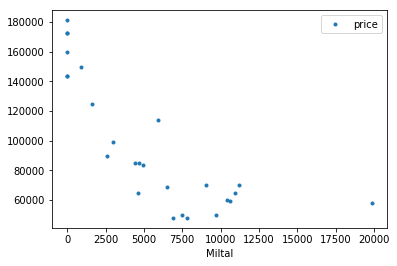

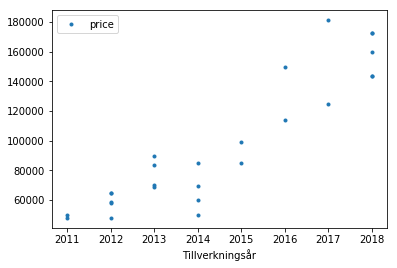

In [204]:

df_cars.plot(x = 'Miltal',y = 'price',style = '.')
df_cars.plot(x = 'Tillverkningsår',y = 'price',style = '.')